<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/ImageNet_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 265 (delta 47), reused 16 (delta 8), pack-reused 183
Receiving objects: 100% (265/265), 218.12 MiB | 32.29 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Checking out files: 100% (30/30), done.
/content/TFG


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from utils import *
from adversarial_attacks import *
import torchvision.models as models
import json
from PIL import Image
import requests

In [4]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [0]:
def denormalize(img, dataset='cifar10'):  # img of size (3,H,W)
  mean = mean_cifar10 if dataset=='cifar10' else mean_ImageNet
  std = std_cifar10 if dataset=='cifar10' else std_ImageNet
  for channel in range(3):
    img[channel] = img[channel] * std[channel] + mean[channel]

  return img

def displayable(img, dataset='cifar10'):  # tensor of size 1xCxHxW
  return np.transpose(denormalize(img.squeeze().numpy(), dataset=dataset), (1,2,0))

In [0]:
def image_loader(url):
  """load image, returns CUDA tensor"""
  transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  img = Image.open(requests.get(url, stream=True).raw)

  return transform(img)

In [153]:
#model = models.resnet50(pretrained=True)
#model = models.densenet169(pretrained=True)
model = models.mobilenet_v2(pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [0]:
img = torch.unsqueeze(image_loader('https://images.freeimages.com/images/large-previews/b31/butterfly-1392408.jpg'), dim=0)
img = img.to(device)

In [155]:
model.eval()
model = model.to(device)
img.requires_grad = True

output = model(img)
pred = output.max(1, keepdim=True)[1]
print('Input image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Input image classified as monarch with a 95.10% confidence


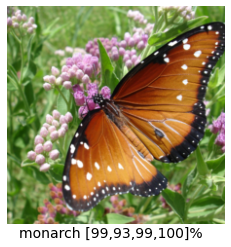

In [156]:
f = plt.figure()
plt.axis('off')
f.text(.50, .08, class_idx[str(pred.item())][1] + ' [99,93,99,100]%', ha='center', fontsize=14)
plt.imshow(displayable(img.clone().detach().cpu(), dataset='imagenet'))

In [0]:
min_rgb = {'cifar10': normalize(torch.tensor([0.,0.,0.], dtype=torch.double), dataset='cifar10'), 'imagenet': normalize(torch.tensor([0.,0.,0.], dtype=torch.double), dataset='imagenet')}
max_rgb = {'cifar10': normalize(torch.tensor([1.,1.,1.], dtype=torch.double), dataset='cifar10'), 'imagenet': normalize(torch.tensor([1.,1.,1.], dtype=torch.double), dataset='imagenet')}

In [162]:
#lb, ub =  valid_bounds(img, 255, dataset='imagenet')
#lb = lb[None, :, :, :].to(device)
#ub = ub[None, :, :, :].to(device)
#adv_x, pert_x, n_iter = sparsefool(model, device, img, pred.item(), lb, ub, max_iter=50)
adv_x, n_iter, scores = one_pixel_attack(model, device, img, pred.item(), dataset='imagenet')
print(n_iter)
print(scores)

Target Probability [Iteration 0]: 0.9466
Target Probability [Iteration 1]: 0.9466
Target Probability [Iteration 2]: 0.9463
Target Probability [Iteration 3]: 0.9457
Target Probability [Iteration 4]: 0.9457
Target Probability [Iteration 5]: 0.9457
Target Probability [Iteration 6]: 0.9457
Target Probability [Iteration 7]: 0.9457
Target Probability [Iteration 8]: 0.9457
Target Probability [Iteration 9]: 0.9457
Target Probability [Iteration 10]: 0.9410
Target Probability [Iteration 11]: 0.9410
Target Probability [Iteration 12]: 0.9410
Target Probability [Iteration 13]: 0.9410
Target Probability [Iteration 14]: 0.9410
Target Probability [Iteration 15]: 0.9410
Target Probability [Iteration 16]: 0.9410
Target Probability [Iteration 17]: 0.9410
Target Probability [Iteration 18]: 0.9410
Target Probability [Iteration 19]: 0.9410
Target Probability [Iteration 20]: 0.9410
Target Probability [Iteration 21]: 0.9410
Target Probability [Iteration 22]: 0.9410
Target Probability [Iteration 23]: 0.9410
Ta

In [150]:
output = model(adv_x)
pred = output.max(1, keepdim=True)[1]
print('Adversarial image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Adversarial image classified as mountain_bike with a 60.34% confidence


Text(0.5, 0.08, 'mountain_bike (60.34%)')

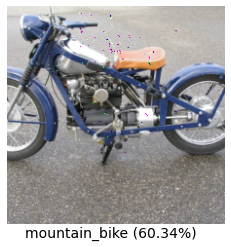

In [151]:
f = plt.figure()
plt.axis('off')
plt.imshow(displayable(adv_x.clone().detach().cpu(), dataset='imagenet'))
f.text(.50, .08, class_idx[str(pred.item())][1] + ' ({:.2f}%)'.format(percentage[pred].item()), ha='center', fontsize=14)

In [102]:
#k = (abs(img-adv_x)).max().item()
k = 0.1
rnd_img = img + k*torch.randn_like(img)
output = model(rnd_img)
pred = output.max(1, keepdim=True)[1]
print('Noisy image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Noisy image classified as moped with a 98.94% confidence


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


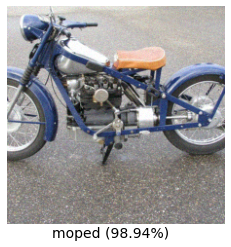

In [103]:
f = plt.figure()
plt.axis('off')
f.text(.50, .08, class_idx[str(pred.item())][1] + ' ({:.2f}%)'.format(percentage[pred].item()), ha='center', fontsize=14)
plt.imshow(displayable(rnd_img.clone().detach().cpu(), dataset='imagenet'))

In [104]:
x = img.clone()
adv = adv_x.clone()
rnd = rnd_img.clone()
print("Initial adv distance {:.4f}".format((x-adv).norm().item()))
print("Initial rnd distance {:.4f}".format((x-rnd).norm().item()))

for i, l in enumerate(model._modules['features']):
  print("\nBlock",i)
  #print("\n", l, "\n")
  #print("Input size: ", x.size())
  x = l(x)
  adv = l(adv)
  rnd = l(rnd)
  print("Output size: ", x.size())

  dist_adv = 0
  dist_rnd = 0
  max_adv = 0
  max_rnd = 0

  for d_x, d_adv, d_rnd in zip(x[0], adv[0], rnd[0]):
    norm_adv = (d_x - d_adv).norm().item()
    norm_rnd = (d_x - d_rnd).norm().item()
    dist_adv += norm_adv
    dist_rnd += norm_rnd
    if norm_adv > max_adv:
      max_adv = norm_adv
    if norm_rnd > max_rnd:
      max_rnd = norm_rnd


  print("\nAvg adv distance {:.4f}".format(dist_adv / x.size(1)))
  print("Avg rnd distance {:.4f}".format(dist_rnd / x.size(1)))

  print("\nMax adv distance {:.4f}".format(max_adv))
  print("Max rnd distance {:.4f}".format(max_rnd))

Initial adv distance 42.0741
Initial rnd distance 38.8655

Block 0
Output size:  torch.Size([1, 32, 112, 112])

Avg adv distance 2.7283
Avg rnd distance 2.0732

Max adv distance 11.3462
Max rnd distance 7.6589

Block 1
Output size:  torch.Size([1, 16, 112, 112])

Avg adv distance 25.3570
Avg rnd distance 21.2263

Max adv distance 36.8885
Max rnd distance 30.6670

Block 2
Output size:  torch.Size([1, 24, 56, 56])

Avg adv distance 10.1804
Avg rnd distance 8.9658

Max adv distance 23.3194
Max rnd distance 15.1557

Block 3
Output size:  torch.Size([1, 24, 56, 56])

Avg adv distance 18.3535
Avg rnd distance 15.7168

Max adv distance 28.0897
Max rnd distance 21.2049

Block 4
Output size:  torch.Size([1, 32, 28, 28])

Avg adv distance 6.2972
Avg rnd distance 5.3061

Max adv distance 10.4032
Max rnd distance 7.4271

Block 5
Output size:  torch.Size([1, 32, 28, 28])

Avg adv distance 7.9043
Avg rnd distance 6.5961

Max adv distance 11.6118
Max rnd distance 8.6622

Block 6
Output size:  torch.S